## v3: Use the extended version of the dataset from ./data_read_and_process-v2.ipynb and experiment with Batch Normalization

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.optimizers import RMSprop

import keras.backend as K
import tensorflow as tf

from decimal import Decimal

import matplotlib.pyplot as plt

## Load the data we created in data_read_and_process.ipynb

In [2]:
X_train = np.load('../train_and_val/X_train_ext.npy')
X_val = np.load('../train_and_val/X_val_ext.npy')
y_train = np.load('../train_and_val/y_train_ext.npy')
y_val = np.load('../train_and_val/y_val_ext.npy')

Verify select statistics remain the same after saving and loading the .npy files

In [3]:
print('Maximum Scaled Duration for X_train: {}'.format(X_train[:, :, -1].max()))
print('Maximum Scaled Duration for X_val: {}'.format(X_val[:, :, -1].max()))
print('Maximum Scaled Duration for y_train: {}'.format(y_train[:, -1].max()))
print('Maximum Scaled Duration for y_val: {}'.format(y_val[:, -1].max()))

Maximum Scaled Duration for X_train: 0.860215053763441
Maximum Scaled Duration for X_val: 0.5516975308641976
Maximum Scaled Duration for y_train: 1.0
Maximum Scaled Duration for y_val: 0.9166666666666667


In [4]:
print('Train-Validation Ratio of the Mean of the Scaled Duration: ', y_train[:, -1].mean() / y_val[:, -1].mean())
print('Train-Validation Ratio of the Stdv of the Scaled Duration: ', y_train[:, -1].std() / y_val[:, -1].std())

Train-Validation Ratio of the Mean of the Scaled Duration:  0.9898257021922111
Train-Validation Ratio of the Stdv of the Scaled Duration:  0.9209054376139967


Indeed, they are.

## Build a Model

### v3: We've added BatchNormalization after each of the hidden layers. 
Note that it preceeds the one 'relu' layer. When this order is switched ('relu' then BatchNormilization) training fails with NaN loss in the first Epoch. It was suggested in this [blog post](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/) to try both orderings. I also include the option to change the momentum parameter of BatchNormalization (default 0.99). We will try with this default value and with a momentum value of 0.0 (use statistics from only the current batch for the normalization)

In [24]:
def lstm(n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512, dropout_rate = 0.4, \
         n_keys_piano = 88, window_size = 16, n_dur_nodes = 20, max_norm_value = None, bn_momentum = 0.99):
    """Generate a keras Sequential model of the form as described in Figure 16 of
    https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972"""
    if (max_norm_value):
        kernel_constraint = tf.keras.constraints.max_norm(max_norm_value)
    else:
        kernel_constraint = None
    model = Sequential()
    model.add(LSTM(n_lstm_nodes, return_sequences = True, input_shape = (window_size, \
                                                        n_keys_piano + n_dur_nodes,)))
    model.add(BatchNormalization(momentum = bn_momentum))
    model.add(Dropout(dropout_rate))
    for i in range(1, n_lstm_layers - 1):
        model.add(LSTM(n_lstm_nodes, return_sequences = True, kernel_constraint = \
                                                           kernel_constraint))
        model.add(BatchNormalization(momentum = bn_momentum))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_lstm_nodes, kernel_constraint = kernel_constraint))
    model.add(BatchNormalization(momentum = bn_momentum))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_lstm_nodes // 2, kernel_constraint = kernel_constraint))
    model.add(BatchNormalization(momentum = bn_momentum))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    for i in range(n_dense_layers - 1):
        model.add(Dense(n_lstm_nodes // 2, kernel_constraint = kernel_constraint))
        model.add(BatchNormalization(momentum = bn_momentum))
        model.add(Dropout(dropout_rate))
    model.add(Dense(n_keys_piano + n_dur_nodes, kernel_constraint = kernel_constraint))
    model.add(Activation('sigmoid'))
    return model

## Custom Loss and Metrics

\begin{equation*}
bce\_loss = \frac{1}{N} (\sum_{i=1}^{N} y_i log(p(y_i)) + (1 - y_i) log(1 - p(y_i)))
\end{equation*}
\begin{equation*}
maestro\_loss = 2 * Harshness \lvert\frac{d_{true} - d_{pred}}{d_{true} + d{_{pred}}}\rvert
\end{equation*}
<br>
\begin{equation*}
total\_loss = MIN(2 * bce\_loss, bce\_loss + maestro\_loss)
\end{equation*}

where N = num_keys_piano, <b>Harshness</b> is a constant to be determined, and <b>d</b> gives the normalized duration. I'll call it the <b>Maestro Loss Function</b> since it pays special attention to the timing of the notes. It is usually composed of a Binary Cross Entropy Term with an additional term proportional to the relative error in duration between $d_{true}$ and $d_{pred}$. However, we limit the total_loss to be less than twice the bce_loss. We also define custom metrics, read the docstrings for their descriptions.

In [6]:
def maestro_loss_wr(harshness, n_dur_nodes): 
    """A loss function which, in addition to penalizing for misclassification on the 
    first n_keys_piano elements, includes a term proportional to the relative
    error in the prediction of the last n_dur_nodes elements (whose mean represents
    the duration). The proportionality constant is the 'harshness' of the maestro in 
    regards to timing."""
    def maestro_loss(ytrue, ypred):
        # Standard binary cross-entropy
        bce_loss = - K.mean(ytrue[:, :-n_dur_nodes] * K.log(ypred[:, :-n_dur_nodes]) + \
                            (1 - ytrue[:, :-n_dur_nodes]) * K.log(1 - ypred[:, :-n_dur_nodes]))

        # Duration error term
        dur_loss = 2 * harshness * K.mean(K.abs(K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                                                K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / \
                                      (K.mean(ytrue[:, -n_dur_nodes:], axis = 1) + \
                                       K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon()))
        
        if (dur_loss > bce_loss):   # Often times, ytrue[:, :-n_dur_nodes] elements will be zero
            return bce_loss * 2     # (for a rest). This may spike dur_loss. To control, I limit it
                                    # so that it never exceeds the bce_loss.
        return bce_loss + dur_loss
    
    return maestro_loss
def precision_mod_wr(n_dur_nodes):
    def precision_mod(ytrue, ypred):
        """Just a modified precision excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        true_positives = K.sum(K.round(ytrue[:, :-n_dur_nodes] * ypred[:, :-n_dur_nodes]))
        pred_positives = K.sum(K.round(ypred[:, :-n_dur_nodes]))
        return true_positives / (pred_positives + K.epsilon())
    return precision_mod

def recall_mod_wr(n_dur_nodes):
    def recall_mod(ytrue, ypred):
        """Just a modified recall excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        true_positives = K.sum(K.round(ytrue[:, :-n_dur_nodes] * ypred[:, :-n_dur_nodes]))
        poss_positives = K.sum(ytrue[:, :-n_dur_nodes])
        return true_positives / (poss_positives + K.epsilon())
    return recall_mod

def f1_score_mod_wr(n_dur_nodes):
    def f1_score_mod(ytrue, ypred):
        """Just a modified f1_score excluding the last n_dur_nodes elements (which are not
        classification nodes)"""

        precision = precision_mod_wr(n_dur_nodes)(ytrue, ypred)
        recall = recall_mod_wr(n_dur_nodes)(ytrue, ypred)   
        return 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score_mod

def dur_error_wr(n_dur_nodes):
    def dur_error(ytrue, ypred):
        """A new metric that only gives information on the error in duration predictions"""
    
        return 2 * K.mean(K.abs((K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                   K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / (K.mean(ytrue[:, -n_dur_nodes:], \
                    axis = 1) + K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon())))
    return dur_error

def maestro_dur_loss_wr(harshness, n_dur_nodes):
    """The second term of the maestro loss, based purely on error in duration predictions.
    To be used as a metric in order to decompose the loss components during analysis"""
    def maestro_dur_loss(ytrue, ypred):

        return 2 * harshness * K.mean(K.abs((K.mean(ytrue[:, -n_dur_nodes:], axis = 1) - \
                                      K.mean(ypred[:, -n_dur_nodes:], axis = 1)) / \
                                      (K.mean(ytrue[:, -n_dur_nodes:], axis = 1) + \
                                      K.mean(ypred[:, -n_dur_nodes:], axis = 1) + K.epsilon())))
    return maestro_dur_loss

In [7]:
def generate_cols_dict(history):
    """return a mapping of desired column names to the corresponding columns in the
    history dictionary (previously history.history where history is the return value
    of model.train)"""
    return {'maestro_loss': history['loss'], 'f1_score': history['f1_score_mod'], \
 'precision': history['precision_mod'], 'recall': history['recall_mod'], \
 'dur_error': history['dur_error'], 'dur_loss': history['maestro_dur_loss'], \
 'val_maestro_loss': history['val_loss'], 'val_f1_score': history['val_f1_score_mod'], \
 'val_precision': history['val_precision_mod'], 'val_recall': history['val_recall_mod'], \
 'val_dur_error': history['val_dur_error'], 'val_dur_loss': history['val_maestro_dur_loss']}

## Training

In [25]:
def train_lstm_model(n_dur_nodes = 20, n_lstm_layers = 2, n_dense_layers = 1, n_lstm_nodes = 512,\
                     dropout_rate = 0.4, batch_size = 512, harshness = 0.05, lr = None, clipnorm = None, \
                     clipvalue = None, max_norm_value = None, bn_momentum = 0.99, epochs = 150):
    """Train a model using the passed parameters, the data, and using the RMSprop optimizer. Write the
    best model as a .h5 and a .csv containing columns for the training and validation custom loss and
    metrics. Returns nothing."""

    model = lstm(n_lstm_layers = n_lstm_layers, n_dense_layers = n_dense_layers, \
                 n_lstm_nodes = n_lstm_nodes, dropout_rate = dropout_rate, max_norm_value = max_norm_value, \
                 bn_momentum = bn_momentum)

    if (lr or clipnorm or clipvalue):
        if (lr):          # It's required that the first argument to RMSprop is not None
            opt = RMSprop(lr = lr, clipnorm = clipnorm, clipvalue = clipvalue)
        elif (clipnorm):
            opt = RMSprop(clipnorm = clipnorm, clipvalue = clipvalue)
        else: # clipvalue
            opt = RMSprop(clipvalue = clipvalue)
    else:
        opt = RMSprop()   # TypeError when all are None, so do this instead
        
    model.compile(loss = maestro_loss_wr(harshness, n_dur_nodes), optimizer = opt, metrics = \
                  [f1_score_mod_wr(n_dur_nodes), recall_mod_wr(n_dur_nodes), precision_mod_wr(n_dur_nodes), \
                   dur_error_wr(n_dur_nodes), maestro_dur_loss_wr(harshness, n_dur_nodes)])
    
    filename = 'best_maestro_model_batchnorm_p_0_ext{0}_{1}_{2}_{3}_{4}'.format(n_dur_nodes, n_lstm_layers, n_dense_layers, \
                                                                  n_lstm_nodes, str(dropout_rate).replace('.', 'pt'))
    if (max_norm_value):
        filename += '_mnv_{}'.format(Decimal(max_norm_value))
    if (lr):
        filename += '_lr_{}'.format('%.0e' % Decimal(lr))
    if (clipnorm):
        filename += '_cn_{}'.format(str(clipnorm).replace('.', 'pt'))     
    if (clipvalue):
        filename += '_cv_{}'.format(str(clipvalue).replace('.', 'pt'))
                                   
    mc = ModelCheckpoint('../models/' + filename + '.h5', monitor = 'val_loss', mode = 'min', \
                                                         save_best_only = True, verbose = 1)
                                   
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, \
                    validation_data = (X_val, y_val), verbose = 2, callbacks = [mc, TerminateOnNaN()])
    
    # In most preliminary tests model training has failed at some point when the loss becomes NaN during
    # validation
    if (len(history.history['val_loss']) < len(history.history['loss'])):  # a NaN during training
        for key, value in history.history.items():
            if (key[:3] == 'val'):          # pd.DataFrame requires value lengths to be equal
                value.append(np.nan)
                
    df = pd.DataFrame(generate_cols_dict(history.history))
    df.index.name = 'Epochs'
    df.to_csv('../model_data/performance_data/' + filename + '.csv')

In [15]:
train_lstm_model()

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.21321, saving model to ../models/best_maestro_model_batchnorm_ext20_2_1_512_0pt4.h5
50/50 - 169s - loss: 0.2460 - f1_score_mod: 0.0488 - recall_mod: 0.0694 - precision_mod: 0.2734 - dur_error: 0.4358 - maestro_dur_loss: 0.0218 - val_loss: 0.2132 - val_f1_score_mod: 0.0000e+00 - val_recall_mod: 0.0000e+00 - val_precision_mod: 0.0000e+00 - val_dur_error: 0.7297 - val_maestro_dur_loss: 0.0365
Epoch 2/150

Epoch 00002: val_loss improved from 0.21321 to 0.20117, saving model to ../models/best_maestro_model_batchnorm_ext20_2_1_512_0pt4.h5
50/50 - 150s - loss: 0.1298 - f1_score_mod: 0.1036 - recall_mod: 0.0575 - precision_mod: 0.5501 - dur_error: 0.3175 - maestro_dur_loss: 0.0159 - val_loss: 0.2012 - val_f1_score_mod: 3.1467e-04 - val_recall_mod: 1.5744e-04 - val_precision_mod: 0.2273 - val_dur_error: 0.7209 - val_maestro_dur_loss: 0.0360
Epoch 3/150

Epoch 00003: val_loss improved from 0.20117 to 0.16952, saving model to ../models/bes

Epoch 20/150

Epoch 00020: val_loss improved from 0.08384 to 0.08345, saving model to ../models/best_maestro_model_batchnorm_ext20_2_1_512_0pt4.h5
50/50 - 142s - loss: 0.0800 - f1_score_mod: 0.4760 - recall_mod: 0.3489 - precision_mod: 0.7498 - dur_error: 0.2068 - maestro_dur_loss: 0.0103 - val_loss: 0.0834 - val_f1_score_mod: 0.4874 - val_recall_mod: 0.3600 - val_precision_mod: 0.7547 - val_dur_error: 0.1940 - val_maestro_dur_loss: 0.0097
Epoch 21/150

Epoch 00021: val_loss did not improve from 0.08345
50/50 - 141s - loss: 0.0787 - f1_score_mod: 0.4861 - recall_mod: 0.3588 - precision_mod: 0.7541 - dur_error: 0.2049 - maestro_dur_loss: 0.0102 - val_loss: 0.0841 - val_f1_score_mod: 0.5014 - val_recall_mod: 0.3828 - val_precision_mod: 0.7272 - val_dur_error: 0.1964 - val_maestro_dur_loss: 0.0098
Epoch 22/150

Epoch 00022: val_loss improved from 0.08345 to 0.08199, saving model to ../models/best_maestro_model_batchnorm_ext20_2_1_512_0pt4.h5
50/50 - 141s - loss: 0.0773 - f1_score_mod: 0.4

Epoch 40/150

Epoch 00040: val_loss did not improve from 0.07528
50/50 - 143s - loss: 0.0601 - f1_score_mod: 0.6440 - recall_mod: 0.5441 - precision_mod: 0.7893 - dur_error: 0.1816 - maestro_dur_loss: 0.0091 - val_loss: 0.0782 - val_f1_score_mod: 0.5975 - val_recall_mod: 0.5017 - val_precision_mod: 0.7385 - val_dur_error: 0.1776 - val_maestro_dur_loss: 0.0089
Epoch 41/150
Batch 32: Invalid loss, terminating training
Batch 33: Invalid loss, terminating training
Batch 34: Invalid loss, terminating training
Batch 35: Invalid loss, terminating training
Batch 36: Invalid loss, terminating training
Batch 37: Invalid loss, terminating training
Batch 38: Invalid loss, terminating training
Batch 39: Invalid loss, terminating training
Batch 40: Invalid loss, terminating training
Batch 41: Invalid loss, terminating training
Batch 42: Invalid loss, terminating training
Batch 43: Invalid loss, terminating training
Batch 44: Invalid loss, terminating training
Batch 45: Invalid loss, terminating trai

Wow, already a significant improvement from the best model (and with half of the parameters)! (a loss of 0.7825 from [chopin-deep-training](https://console.paperspace.com/tedxjaqax/notebook/rlcubrhq4zrvpe) compared with 0.7528 here. Let's try with 0 momentum.

In [26]:
train_lstm_model(bn_momentum = 0.0)

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.12951, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4.h5
50/50 - 186s - loss: 0.2461 - f1_score_mod: 0.0509 - recall_mod: 0.0746 - precision_mod: 0.3022 - dur_error: 0.4518 - maestro_dur_loss: 0.0226 - val_loss: 0.1295 - val_f1_score_mod: 0.0217 - val_recall_mod: 0.0110 - val_precision_mod: 0.8578 - val_dur_error: 0.2809 - val_maestro_dur_loss: 0.0140
Epoch 2/150

Epoch 00002: val_loss improved from 0.12951 to 0.11547, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4.h5
50/50 - 149s - loss: 0.1295 - f1_score_mod: 0.1015 - recall_mod: 0.0560 - precision_mod: 0.5642 - dur_error: 0.3130 - maestro_dur_loss: 0.0157 - val_loss: 0.1155 - val_f1_score_mod: 0.1295 - val_recall_mod: 0.0708 - val_precision_mod: 0.7734 - val_dur_error: 0.2928 - val_maestro_dur_loss: 0.0146
Epoch 3/150

Epoch 00003: val_loss improved from 0.11547 to 0.10774, saving model to ../models/best_maestro_mo

Epoch 20/150

Epoch 00020: val_loss improved from 0.08319 to 0.08205, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4.h5
50/50 - 162s - loss: 0.0799 - f1_score_mod: 0.4750 - recall_mod: 0.3473 - precision_mod: 0.7520 - dur_error: 0.2046 - maestro_dur_loss: 0.0102 - val_loss: 0.0821 - val_f1_score_mod: 0.4981 - val_recall_mod: 0.3687 - val_precision_mod: 0.7679 - val_dur_error: 0.1913 - val_maestro_dur_loss: 0.0096
Epoch 21/150

Epoch 00021: val_loss improved from 0.08205 to 0.08140, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4.h5
50/50 - 160s - loss: 0.0789 - f1_score_mod: 0.4849 - recall_mod: 0.3577 - precision_mod: 0.7532 - dur_error: 0.2033 - maestro_dur_loss: 0.0102 - val_loss: 0.0814 - val_f1_score_mod: 0.5060 - val_recall_mod: 0.3782 - val_precision_mod: 0.7652 - val_dur_error: 0.1908 - val_maestro_dur_loss: 0.0095
Epoch 22/150

Epoch 00022: val_loss improved from 0.08140 to 0.08123, saving model to ../models/best_mae

Epoch 40/150

Epoch 00040: val_loss improved from 0.07466 to 0.07361, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4.h5
50/50 - 144s - loss: 0.0604 - f1_score_mod: 0.6417 - recall_mod: 0.5414 - precision_mod: 0.7879 - dur_error: 0.1811 - maestro_dur_loss: 0.0091 - val_loss: 0.0736 - val_f1_score_mod: 0.6032 - val_recall_mod: 0.5007 - val_precision_mod: 0.7589 - val_dur_error: 0.1723 - val_maestro_dur_loss: 0.0086
Epoch 41/150
Batch 29: Invalid loss, terminating training
Batch 30: Invalid loss, terminating training
Batch 31: Invalid loss, terminating training
Batch 32: Invalid loss, terminating training
Batch 33: Invalid loss, terminating training
Batch 34: Invalid loss, terminating training
Batch 35: Invalid loss, terminating training
Batch 36: Invalid loss, terminating training
Batch 37: Invalid loss, terminating training
Batch 38: Invalid loss, terminating training
Batch 39: Invalid loss, terminating training
Batch 40: Invalid loss, terminating training

Slightly better than before. We'll use a zero momentum from now on. Also, both were still improving. It is then wise to try to get the training to last longer. We'll try halving the learning rate first.

In [27]:
train_lstm_model(lr = 0.0005, bn_momentum = 0.0)

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.15581, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 148s - loss: 0.3576 - f1_score_mod: 0.0643 - recall_mod: 0.1476 - precision_mod: 0.1007 - dur_error: 0.6020 - maestro_dur_loss: 0.0301 - val_loss: 0.1558 - val_f1_score_mod: 0.0111 - val_recall_mod: 0.0056 - val_precision_mod: 0.7740 - val_dur_error: 0.3581 - val_maestro_dur_loss: 0.0179
Epoch 2/150

Epoch 00002: val_loss improved from 0.15581 to 0.12260, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 146s - loss: 0.1498 - f1_score_mod: 0.0456 - recall_mod: 0.0240 - precision_mod: 0.4686 - dur_error: 0.3355 - maestro_dur_loss: 0.0168 - val_loss: 0.1226 - val_f1_score_mod: 0.0739 - val_recall_mod: 0.0389 - val_precision_mod: 0.7836 - val_dur_error: 0.2839 - val_maestro_dur_loss: 0.0142
Epoch 3/150

Epoch 00003: val_loss improved from 0.12260 to 0.11352, saving model to ../mode

Epoch 19/150

Epoch 00019: val_loss improved from 0.09147 to 0.09032, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 143s - loss: 0.0928 - f1_score_mod: 0.3597 - recall_mod: 0.2391 - precision_mod: 0.7275 - dur_error: 0.2291 - maestro_dur_loss: 0.0115 - val_loss: 0.0903 - val_f1_score_mod: 0.3885 - val_recall_mod: 0.2604 - val_precision_mod: 0.7663 - val_dur_error: 0.2095 - val_maestro_dur_loss: 0.0105
Epoch 20/150

Epoch 00020: val_loss did not improve from 0.09032
50/50 - 144s - loss: 0.0915 - f1_score_mod: 0.3684 - recall_mod: 0.2464 - precision_mod: 0.7306 - dur_error: 0.2271 - maestro_dur_loss: 0.0114 - val_loss: 0.0905 - val_f1_score_mod: 0.3891 - val_recall_mod: 0.2595 - val_precision_mod: 0.7790 - val_dur_error: 0.2150 - val_maestro_dur_loss: 0.0108
Epoch 21/150

Epoch 00021: val_loss improved from 0.09032 to 0.08981, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 143s - loss: 

Epoch 38/150

Epoch 00038: val_loss did not improve from 0.08136
50/50 - 143s - loss: 0.0747 - f1_score_mod: 0.5193 - recall_mod: 0.3955 - precision_mod: 0.7569 - dur_error: 0.2050 - maestro_dur_loss: 0.0103 - val_loss: 0.0826 - val_f1_score_mod: 0.5150 - val_recall_mod: 0.4004 - val_precision_mod: 0.7219 - val_dur_error: 0.2001 - val_maestro_dur_loss: 0.0100
Epoch 39/150

Epoch 00039: val_loss did not improve from 0.08136
50/50 - 144s - loss: 0.0737 - f1_score_mod: 0.5282 - recall_mod: 0.4043 - precision_mod: 0.7622 - dur_error: 0.2021 - maestro_dur_loss: 0.0101 - val_loss: 0.0834 - val_f1_score_mod: 0.5329 - val_recall_mod: 0.4355 - val_precision_mod: 0.6869 - val_dur_error: 0.2017 - val_maestro_dur_loss: 0.0101
Epoch 40/150

Epoch 00040: val_loss improved from 0.08136 to 0.08059, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 144s - loss: 0.0730 - f1_score_mod: 0.5361 - recall_mod: 0.4129 - precision_mod: 0.7650 - dur_error: 0.2020 

Epoch 59/150

Epoch 00059: val_loss did not improve from 0.07673
50/50 - 143s - loss: 0.0603 - f1_score_mod: 0.6411 - recall_mod: 0.5393 - precision_mod: 0.7907 - dur_error: 0.1888 - maestro_dur_loss: 0.0094 - val_loss: 0.0790 - val_f1_score_mod: 0.5864 - val_recall_mod: 0.4930 - val_precision_mod: 0.7237 - val_dur_error: 0.1888 - val_maestro_dur_loss: 0.0094
Epoch 60/150

Epoch 00060: val_loss improved from 0.07673 to 0.07671, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_lr_5e-04.h5
50/50 - 143s - loss: 0.0599 - f1_score_mod: 0.6443 - recall_mod: 0.5436 - precision_mod: 0.7913 - dur_error: 0.1887 - maestro_dur_loss: 0.0094 - val_loss: 0.0767 - val_f1_score_mod: 0.5920 - val_recall_mod: 0.4965 - val_precision_mod: 0.7334 - val_dur_error: 0.1911 - val_maestro_dur_loss: 0.0096
Epoch 61/150

Epoch 00061: val_loss did not improve from 0.07671
50/50 - 143s - loss: 0.0594 - f1_score_mod: 0.6486 - recall_mod: 0.5483 - precision_mod: 0.7943 - dur_error: 0.1888 

No success here. It might benefit us to use the set a MaxNorm kernel constraint as in ./model_training-v2.ipynb. However, I wonder if the weight statistics have changed in response to this batch normalization. So I will do a run to extract these as in ./model_training-v2.ipynb.

In [29]:
def get_gradient_norms_by_layer_func(model):
    """Returns the norm of the gradients of the input weight matrix by layer"""

    norms_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        grads = K.gradients(model.total_loss, layer.trainable_weights)
        summed_squares = [K.sum(K.square(g)) for g in grads]
        norm = K.sqrt(sum(summed_squares))
        norms_by_layer.append(norm)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norms_by_layer])

def get_gradient_stats_by_layer_func(model):
    """Returns the gradient statistics of the model by layer"""
    
    means_by_layer = []
    minima_by_layer = []
    maxima_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue   # No trainable weights
        grads = K.gradients(model.total_loss, layer.trainable_weights)
        means_by_layer.append([K.mean(g) for g in grads])
        minima_by_layer.append([K.min(g) for g in grads])
        maxima_by_layer.append([K.max(g) for g in grads])
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means_by_layer, minima_by_layer, maxima_by_layer])

def get_weight_norms_by_layer_func(model):
    """Returns the norm of the input weight matrix by layer"""

    norms_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        weights = layer.trainable_weights
        summed_squares = [K.sum(K.square(w)) for w in weights]
        norm = K.sqrt(sum(summed_squares))
        norms_by_layer.append(norm)
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [norms_by_layer])

def get_max_weight_vector_norms_by_layer_func(model):
    """Returns the maximum norm of the input weight vectors by layer"""

    max_weight_vector_norm_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue    # No trainable weights
        weights = layer.trainable_weights[0] # Take the kernel (no recurrent_kernel or bias)
        input_weights_tensor = tf.convert_to_tensor(weights)  # can't slice variable
        norms = [K.sqrt(K.sum(K.square(input_weights_tensor[i, :]))) for i in range(input_weights_tensor.shape[0])]
        max_weight_vector_norm_by_layer.append(K.max(norms))
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [max_weight_vector_norm_by_layer])

def get_weight_stats_by_layer_func(model):
    """Returns the weights statistics of the model by layer"""
    
    means_by_layer = []
    minima_by_layer = []
    maxima_by_layer = []
    for layer in model.layers:
        if (type(layer) not in [tf.python.keras.layers.recurrent_v2.LSTM, \
                            tf.python.keras.layers.core.Dense]):
            continue   # No trainable weights
        weights = layer.trainable_weights
        means_by_layer.append([K.mean(w) for w in weights])
        minima_by_layer.append([K.min(w) for w in weights])
        maxima_by_layer.append([K.max(w) for w in weights])
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    return K.function(inputs, [means_by_layer, minima_by_layer, maxima_by_layer])


In [30]:
tf.compat.v1.disable_eager_execution()   # For some reason, I need to do this to have
                                         # access to total_loss. It's strange because 
                                         # model.run_eagerly = False both before and 
                                         # after running the command, as it should.
model = lstm(bn_momentum = 0)
n_layers = 4
harshness = 0.05
n_dur_nodes = 20
model.compile(loss = maestro_loss_wr(harshness, n_dur_nodes), optimizer = RMSprop())

get_gradient_norms_by_layer = get_gradient_norms_by_layer_func(model)
get_gradient_stats_by_layer = get_gradient_stats_by_layer_func(model)
get_weight_norms_by_layer = get_weight_norms_by_layer_func(model)
get_weight_stats_by_layer = get_weight_stats_by_layer_func(model)
get_max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer_func(model)
grad_norms_by_layer_by_batch = []
grad_stats_by_layer_by_batch = []
weight_norms_by_layer_by_batch = []
weight_stats_by_layer_by_batch = []
max_weight_vector_norms_by_layer_by_batch = []
batch_size = 512
epochs = 50
# We just need to pass placeholder arrays of shape (?, window_size, 88),
# (?, n_keys_piano + 1) and (n_keys_piano + 1)
func_input = [X_train[:2], y_train[:2], np.ones(2)]
for i in range(epochs):
    print('Epoch {}:'.format(i + 1))
    for j in range(len(y_train) // batch_size):
        model.train_on_batch(X_train[j * batch_size: (j + 1) * batch_size], \
                             y_train[j * batch_size: (j + 1) * batch_size])
        
        gradient_norms_by_layer = get_gradient_norms_by_layer(func_input)
        gradient_stats_by_layer = get_gradient_stats_by_layer(func_input)
        weight_norms_by_layer = get_weight_norms_by_layer(func_input)
        weight_stats_by_layer = get_weight_stats_by_layer(func_input)
        max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer(func_input)

        grad_means_by_layer = []
        grad_maxima_by_layer = []
        grad_minima_by_layer = []
        weight_means_by_layer = []
        weight_maxima_by_layer = []
        weight_minima_by_layer = []
        for k in range(n_layers):
            grad_means_by_layer.append(np.mean(gradient_stats_by_layer[0][k]))
            grad_minima_by_layer.append(min(gradient_stats_by_layer[1][k]))
            grad_maxima_by_layer.append(max(gradient_stats_by_layer[2][k]))
            weight_means_by_layer.append(np.mean(weight_stats_by_layer[0][k]))
            weight_minima_by_layer.append(min(weight_stats_by_layer[1][k]))
            weight_maxima_by_layer.append(max(weight_stats_by_layer[2][k]))
        print('batch {}'.format(j))
        grad_norms_by_layer_by_batch.append(gradient_norms_by_layer)
        weight_norms_by_layer_by_batch.append(weight_norms_by_layer)
        grad_stats_by_layer_by_batch.append([grad_means_by_layer, grad_minima_by_layer, grad_maxima_by_layer])
        weight_stats_by_layer_by_batch.append([weight_means_by_layer, weight_minima_by_layer, weight_maxima_by_layer])
        max_weight_vector_norms_by_layer_by_batch.append(max_weight_vector_norms_by_layer)
        
    model.train_on_batch(X_train[(j + 1) * batch_size:], y_train[(j + 1) * batch_size:])
    
    gradient_norms_by_layer = get_gradient_norms_by_layer(func_input)
    gradient_stats_by_layer = get_gradient_stats_by_layer(func_input)
    weight_norms_by_layer = get_weight_norms_by_layer(func_input)
    weight_stats_by_layer = get_weight_stats_by_layer(func_input)
    max_weight_vector_norms_by_layer = get_max_weight_vector_norms_by_layer(func_input)

    grad_means_by_layer = []
    grad_maxima_by_layer = []
    grad_minima_by_layer = []
    weight_means_by_layer = []
    weight_maxima_by_layer = []
    weight_minima_by_layer = []
    for k in range(n_layers):
        grad_means_by_layer.append(np.mean(gradient_stats_by_layer[0][k]))
        grad_minima_by_layer.append(min(gradient_stats_by_layer[1][k]))
        grad_maxima_by_layer.append(max(gradient_stats_by_layer[2][k]))
        weight_means_by_layer.append(np.mean(weight_stats_by_layer[0][k]))
        weight_minima_by_layer.append(min(weight_stats_by_layer[1][k]))
        weight_maxima_by_layer.append(max(weight_stats_by_layer[2][k]))
    print('batch {}'.format(j))
    grad_norms_by_layer_by_batch.append(gradient_norms_by_layer)
    weight_norms_by_layer_by_batch.append(weight_norms_by_layer)
    grad_stats_by_layer_by_batch.append([grad_means_by_layer, grad_minima_by_layer, grad_maxima_by_layer])
    weight_stats_by_layer_by_batch.append([weight_means_by_layer, weight_minima_by_layer, weight_maxima_by_layer])
    max_weight_vector_norms_by_layer_by_batch.append(max_weight_vector_norms_by_layer)

Epoch 1:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 2:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 3:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batc

batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 20:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 21:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
b

batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 38:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 48
Epoch 39:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
b

In [31]:
# Combine the dataframes
df_grad_norms = pd.DataFrame(grad_norms_by_layer_by_batch)
df_grad_stats = pd.DataFrame(grad_stats_by_layer_by_batch)
df_weight_norms = pd.DataFrame(weight_norms_by_layer_by_batch)
df_weight_stats = pd.DataFrame(weight_stats_by_layer_by_batch)
df_max_weight_vector_norms = pd.DataFrame(max_weight_vector_norms_by_layer_by_batch)

In [32]:
df_weight_norms

,0
0,"[35.201504, 43.144085, 18.520008, 12.324624]"
1,"[35.261868, 43.24366, 18.539328, 12.342776]"
2,"[35.300667, 43.306347, 18.55139, 12.365157]"
3,"[35.329197, 43.35868, 18.560684, 12.39096]"
4,"[35.351177, 43.400112, 18.568216, 12.417303]"
...,...
2495,"[nan, nan, nan, nan]"
2496,"[nan, nan, nan, nan]"
2497,"[nan, nan, nan, nan]"
2498,"[nan, nan, nan, nan]"


In [255]:
df_max_weight_vector_norms

,0
0,"[1.4146488, 1.311044, 0.8973749, 0.84622324]"
1,"[1.4301114, 1.3200884, 0.8969019, 0.8549081]"
2,"[1.4297501, 1.3235296, 0.89825344, 0.8600329]"
3,"[1.4307065, 1.3266822, 0.8984509, 0.8661041]"
4,"[1.4299542, 1.3263229, 0.8995419, 0.8619358]"
...,...
1995,"[-inf, -inf, -inf, -inf]"
1996,"[-inf, -inf, -inf, -inf]"
1997,"[-inf, -inf, -inf, -inf]"
1998,"[-inf, -inf, -inf, -inf]"


In [33]:
layer_list = ['lstm_1', 'lstm_2', 'dense_1', 'dense_2']
df_grad_norms = pd.DataFrame([x[0] for x in df_grad_norms.values], columns = layer_list).dropna()
df_weight_norms = pd.DataFrame([x[0] for x in df_weight_norms.values], columns = layer_list).dropna()
df_max_weight_vector_norms = pd.DataFrame([x[0] for x in df_max_weight_vector_norms.values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
batches_per_epoch = 49
df_grad_norms.index = pd.MultiIndex.from_tuples([((batch // batches_per_epoch) + 1, batch) \
                    for batch in range(1, len(df_grad_norms) + 1)], names = ('Epoch', 'Batch'))
df_weight_norms.index = df_grad_norms.index
df_max_weight_vector_norms.index = df_grad_norms.index

In [34]:
df_grad_means = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 0]).values], columns = layer_list).dropna()
df_grad_means.index = df_grad_norms.index
df_grad_minima = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 1]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_grad_minima.index = df_grad_norms.index
df_grad_maxima = pd.DataFrame([x[0] for x in pd.DataFrame(df_grad_stats.iloc[:, 2]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_grad_maxima.index = df_grad_norms.index

df_weight_means = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 0]).values], columns = layer_list).dropna()
df_weight_means.index = df_grad_norms.index
df_weight_minima = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 1]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_weight_minima.index = df_grad_norms.index
df_weight_maxima = pd.DataFrame([x[0] for x in pd.DataFrame(df_weight_stats.iloc[:, 2]).values], columns = layer_list).replace([np.inf, -np.inf], np.nan).dropna()
df_weight_maxima.index = df_grad_norms.index

In [35]:
# Save the data so we don't have to re-run the model
df_grad_norms.to_csv('../model_data/gradient_data/gradient_norms_bn_ext_2_1_512_0pt4.csv')
df_grad_means.to_csv('../model_data/gradient_data/gradient_means_bn_ext_2_1_512_0pt4.csv')
df_grad_minima.to_csv('../model_data/gradient_data/gradient_minima_bn_ext_2_1_512_0pt4.csv')
df_grad_maxima.to_csv('../model_data/gradient_data/gradient_maxima_bn_ext_2_1_512_0pt4.csv')

df_weight_norms.to_csv('../model_data/weight_data/weight_norms_bn_ext_2_1_512_0pt4.csv')
df_weight_means.to_csv('../model_data/weight_data/weight_means_bn_ext_2_1_512_0pt4.csv')
df_weight_minima.to_csv('../model_data/weight_data/weight_minima_bn_ext_2_1_512_0pt4.csv')
df_weight_maxima.to_csv('../model_data/weight_data/weight_maxima_bn_ext_2_1_512_0pt4.csv')
df_max_weight_vector_norms.to_csv('../model_data/weight_data/max_weight_vector_norms_bn_ext_2_1_512_0pt4.csv')

In [36]:
df_grad_norms = pd.read_csv('../model_data/gradient_data/gradient_norms_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_means = pd.read_csv('../model_data/gradient_data/gradient_means_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_minima = pd.read_csv('../model_data/gradient_data/gradient_minima_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_grad_maxima = pd.read_csv('../model_data/gradient_data/gradient_maxima_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])

df_weight_norms = pd.read_csv('../model_data/weight_data/weight_norms_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_means = pd.read_csv('../model_data/weight_data/weight_means_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_minima = pd.read_csv('../model_data/weight_data/weight_minima_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_weight_maxima = pd.read_csv('../model_data/weight_data/weight_maxima_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])
df_max_weight_vector_norms = pd.read_csv('../model_data/weight_data/max_weight_vector_norms_bn_ext_2_1_512_0pt4.csv', index_col = [0, 1])

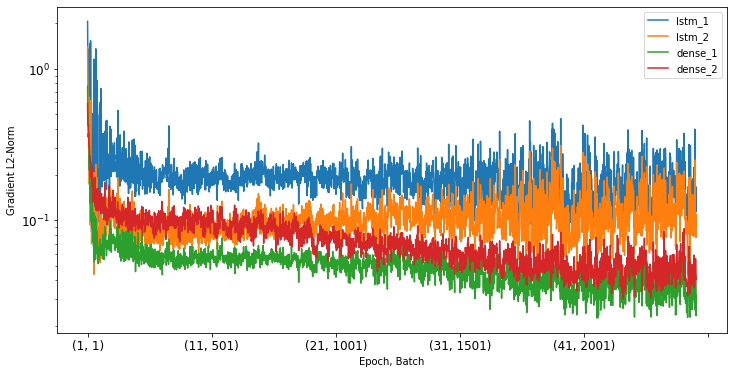

In [37]:
df_grad_norms.plot(figsize = (12, 6), logy = True, xlabel = 'Epoch, Batch', \
             ylabel = 'Gradient L2-Norm', fontsize = 12)

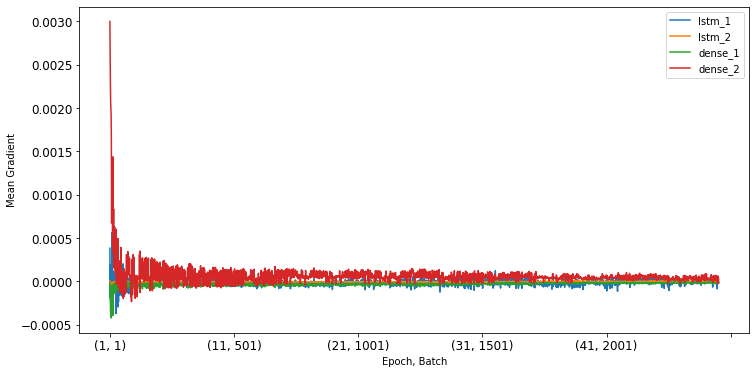

In [38]:
df_grad_means.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Mean Gradient', figsize = (12, 6), fontsize = 12)

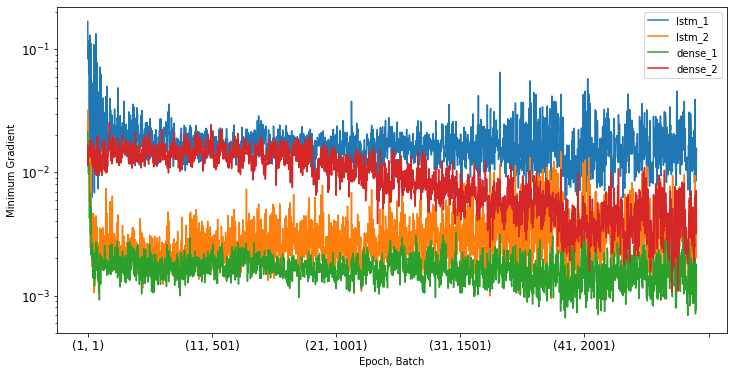

In [39]:
df_grad_minima.abs().plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Minimum Gradient', logy = True, figsize = (12, 6), fontsize = 12)


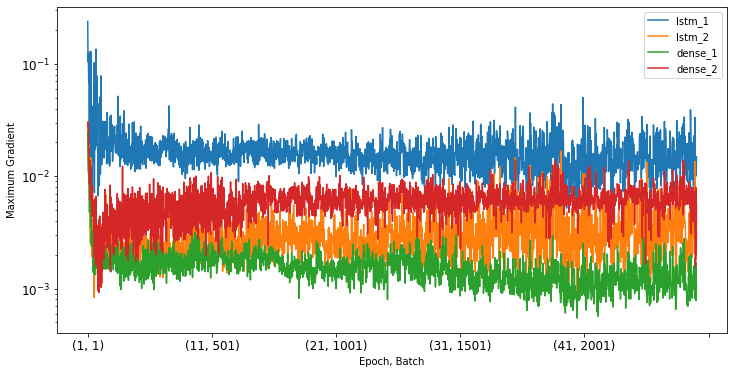

In [40]:
df_grad_maxima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Gradient', logy = True, figsize = (12, 6), fontsize = 12)

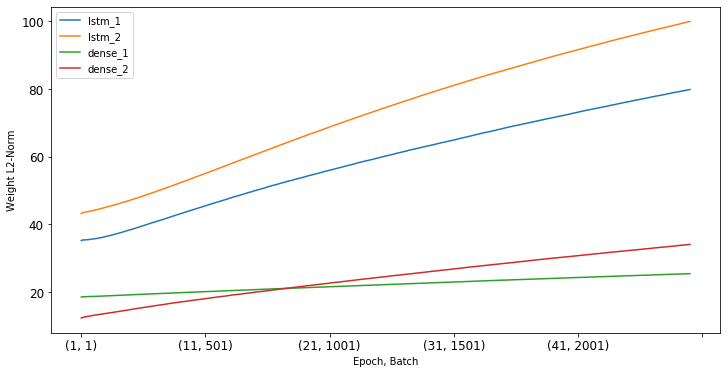

In [41]:
df_weight_norms.plot(figsize = (12, 6), xlabel = 'Epoch, Batch', \
             ylabel = 'Weight L2-Norm', fontsize = 12)

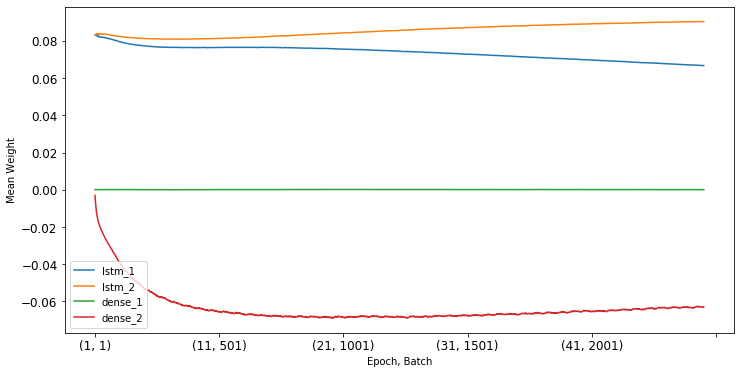

In [42]:
df_weight_means.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Mean Weight', figsize = (12, 6), fontsize = 12)

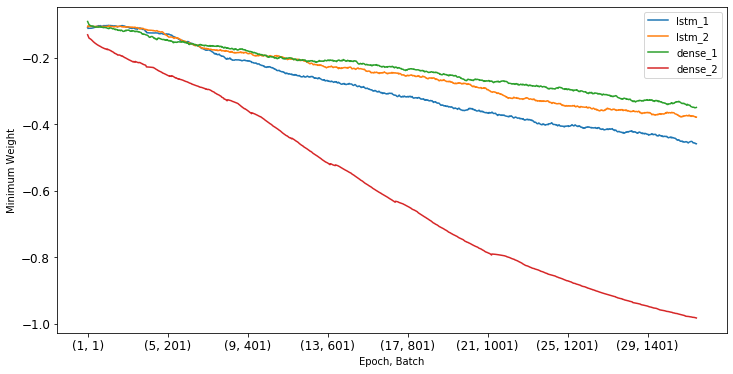

In [27]:
df_weight_minima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Minimum Weight',  figsize = (12, 6), fontsize = 12)

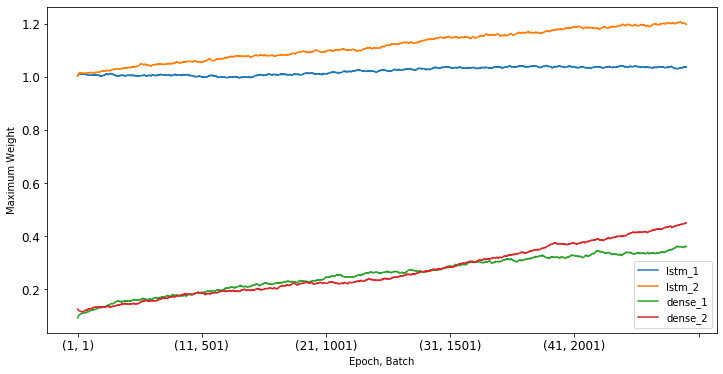

In [43]:
df_weight_maxima.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Weight',  figsize = (12, 6), fontsize = 12)

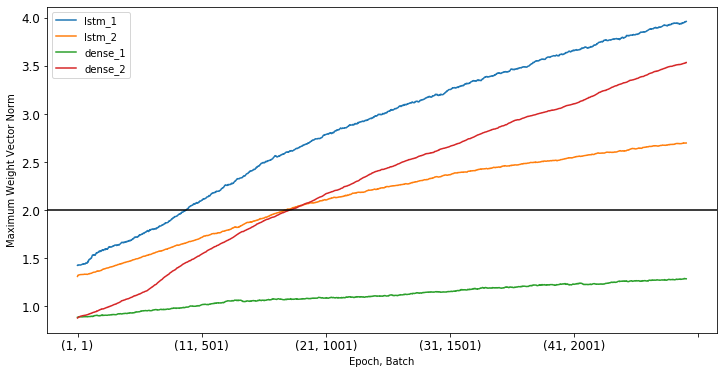

In [55]:
df_max_weight_vector_norms.plot(xlabel = 'Epoch, Batch', \
             ylabel = 'Maximum Weight Vector Norm',  figsize = (12, 6), fontsize = 12)
plt.axhline(2.0, color = 'k')

The above is the important plot for informing our MaxNorm value. It seems the evolution of these statistics is very similar to how it was without BatchNormalization (in ./model_training-v2.ipynb). Therefore, we will use the same max_norm_value of 2.

In [45]:
train_lstm_model(max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.12887, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 158s - loss: 0.2427 - f1_score_mod: 0.0407 - recall_mod: 0.0608 - precision_mod: 0.2818 - dur_error: 0.4495 - maestro_dur_loss: 0.0225 - val_loss: 0.1289 - val_f1_score_mod: 0.0363 - val_recall_mod: 0.0186 - val_precision_mod: 0.7974 - val_dur_error: 0.3299 - val_maestro_dur_loss: 0.0165
Epoch 2/150

Epoch 00002: val_loss improved from 0.12887 to 0.11406, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 170s - loss: 0.1295 - f1_score_mod: 0.0973 - recall_mod: 0.0536 - precision_mod: 0.5592 - dur_error: 0.3128 - maestro_dur_loss: 0.0156 - val_loss: 0.1141 - val_f1_score_mod: 0.1582 - val_recall_mod: 0.0884 - 

Epoch 18/150

Epoch 00018: val_loss did not improve from 0.08436
25307/25307 - 140s - loss: 0.0824 - f1_score_mod: 0.4531 - recall_mod: 0.3255 - precision_mod: 0.7460 - dur_error: 0.2058 - maestro_dur_loss: 0.0103 - val_loss: 0.0844 - val_f1_score_mod: 0.4670 - val_recall_mod: 0.3390 - val_precision_mod: 0.7517 - val_dur_error: 0.1935 - val_maestro_dur_loss: 0.0097
Epoch 19/150

Epoch 00019: val_loss improved from 0.08436 to 0.08336, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 141s - loss: 0.0809 - f1_score_mod: 0.4672 - recall_mod: 0.3393 - precision_mod: 0.7504 - dur_error: 0.2040 - maestro_dur_loss: 0.0102 - val_loss: 0.0834 - val_f1_score_mod: 0.4569 - val_recall_mod: 0.3213 - val_precision_mod: 0.7924 - val_dur_error: 0.1906 - val_maestro_dur_loss: 0.0095
Epoch 20/150

Epoch 00020: val_loss improved from 0.08336 to 0.08290, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 1

Epoch 38/150

Epoch 00038: val_loss did not improve from 0.07509
25307/25307 - 143s - loss: 0.0615 - f1_score_mod: 0.6328 - recall_mod: 0.5265 - precision_mod: 0.7935 - dur_error: 0.1834 - maestro_dur_loss: 0.0092 - val_loss: 0.0757 - val_f1_score_mod: 0.5971 - val_recall_mod: 0.5028 - val_precision_mod: 0.7355 - val_dur_error: 0.1784 - val_maestro_dur_loss: 0.0089
Epoch 39/150

Epoch 00039: val_loss improved from 0.07509 to 0.07504, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 144s - loss: 0.0610 - f1_score_mod: 0.6358 - recall_mod: 0.5310 - precision_mod: 0.7926 - dur_error: 0.1823 - maestro_dur_loss: 0.0091 - val_loss: 0.0750 - val_f1_score_mod: 0.5984 - val_recall_mod: 0.4945 - val_precision_mod: 0.7582 - val_dur_error: 0.1797 - val_maestro_dur_loss: 0.0090
Epoch 40/150

Epoch 00040: val_loss improved from 0.07504 to 0.07439, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 1


Epoch 00059: val_loss did not improve from 0.07397
25307/25307 - 142s - loss: 0.0492 - f1_score_mod: 0.7242 - recall_mod: 0.6445 - precision_mod: 0.8268 - dur_error: 0.1701 - maestro_dur_loss: 0.0085 - val_loss: 0.0756 - val_f1_score_mod: 0.6320 - val_recall_mod: 0.5450 - val_precision_mod: 0.7523 - val_dur_error: 0.1708 - val_maestro_dur_loss: 0.0085
Epoch 60/150

Epoch 00060: val_loss improved from 0.07397 to 0.07379, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt4_mnv_2.h5
25307/25307 - 142s - loss: 0.0488 - f1_score_mod: 0.7299 - recall_mod: 0.6521 - precision_mod: 0.8291 - dur_error: 0.1695 - maestro_dur_loss: 0.0085 - val_loss: 0.0738 - val_f1_score_mod: 0.6419 - val_recall_mod: 0.5684 - val_precision_mod: 0.7376 - val_dur_error: 0.1673 - val_maestro_dur_loss: 0.0084
Epoch 61/150

Epoch 00061: val_loss did not improve from 0.07379
25307/25307 - 142s - loss: 0.0482 - f1_score_mod: 0.7326 - recall_mod: 0.6555 - precision_mod: 0.8307 - dur_error: 0.169

Epoch 82/150

Epoch 00082: val_loss did not improve from 0.07379
25307/25307 - 142s - loss: 0.0410 - f1_score_mod: 0.7850 - recall_mod: 0.7266 - precision_mod: 0.8540 - dur_error: 0.1603 - maestro_dur_loss: 0.0080 - val_loss: 0.0781 - val_f1_score_mod: 0.6562 - val_recall_mod: 0.5895 - val_precision_mod: 0.7405 - val_dur_error: 0.1740 - val_maestro_dur_loss: 0.0087
Epoch 83/150

Epoch 00083: val_loss did not improve from 0.07379
25307/25307 - 142s - loss: 0.0407 - f1_score_mod: 0.7877 - recall_mod: 0.7313 - precision_mod: 0.8539 - dur_error: 0.1600 - maestro_dur_loss: 0.0080 - val_loss: 0.0770 - val_f1_score_mod: 0.6558 - val_recall_mod: 0.5869 - val_precision_mod: 0.7432 - val_dur_error: 0.1596 - val_maestro_dur_loss: 0.0080
Epoch 84/150

Epoch 00084: val_loss did not improve from 0.07379
25307/25307 - 142s - loss: 0.0406 - f1_score_mod: 0.7881 - recall_mod: 0.7319 - precision_mod: 0.8539 - dur_error: 0.1595 - maestro_dur_loss: 0.0080 - val_loss: 0.0781 - val_f1_score_mod: 0.6559 - va

As before, adding the MaxNorm constraint does allow training to proceed much farther. However we have not achieved a better model here. Lastly, I will try reducing the dropout_rate since I tried increasing this parameter in ./model_training-v2.ipynb without success.

In [49]:
train_lstm_model(dropout_rate = 0.35, max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.13415, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35_mnv_2.h5
25307/25307 - 163s - loss: 0.2402 - f1_score_mod: 0.0505 - recall_mod: 0.0719 - precision_mod: 0.3448 - dur_error: 0.4489 - maestro_dur_loss: 0.0224 - val_loss: 0.1341 - val_f1_score_mod: 0.0256 - val_recall_mod: 0.0130 - val_precision_mod: 0.7658 - val_dur_error: 0.3144 - val_maestro_dur_loss: 0.0157
Epoch 2/150

Epoch 00002: val_loss improved from 0.13415 to 0.11335, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35_mnv_2.h5
25307/25307 - 153s - loss: 0.1278 - f1_score_mod: 0.1068 - recall_mod: 0.0591 - precision_mod: 0.5873 - dur_error: 0.3195 - maestro_dur_loss: 0.0160 - val_loss: 0.1134 - val_f1_score_mod: 0.1352 - val_recall_mod: 0.0740 - val_precision_mod: 0.7875 - val_dur_error: 0.2720 - val_maestro_dur_loss: 0.0136
Epoch 3/150

Epoch 00003: val_loss

Epoch 19/150

Epoch 00019: val_loss improved from 0.08185 to 0.08086, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35_mnv_2.h5
25307/25307 - 155s - loss: 0.0760 - f1_score_mod: 0.5140 - recall_mod: 0.3874 - precision_mod: 0.7643 - dur_error: 0.2006 - maestro_dur_loss: 0.0100 - val_loss: 0.0809 - val_f1_score_mod: 0.5032 - val_recall_mod: 0.3747 - val_precision_mod: 0.7664 - val_dur_error: 0.1922 - val_maestro_dur_loss: 0.0096
Epoch 20/150

Epoch 00020: val_loss improved from 0.08086 to 0.07990, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35_mnv_2.h5
25307/25307 - 177s - loss: 0.0744 - f1_score_mod: 0.5271 - recall_mod: 0.4020 - precision_mod: 0.7657 - dur_error: 0.1971 - maestro_dur_loss: 0.0099 - val_loss: 0.0799 - val_f1_score_mod: 0.5166 - val_recall_mod: 0.3872 - val_precision_mod: 0.7771 - val_dur_error: 0.1858 - val_maestro_dur_loss: 0.0093
Epoch 21/150

Epoch 00021: val_loss improved from 0.07990 to 0.07941, saving m

Epoch 39/150

Epoch 00039: val_loss did not improve from 0.07338
25307/25307 - 182s - loss: 0.0540 - f1_score_mod: 0.6924 - recall_mod: 0.5980 - precision_mod: 0.8224 - dur_error: 0.1760 - maestro_dur_loss: 0.0088 - val_loss: 0.0738 - val_f1_score_mod: 0.6247 - val_recall_mod: 0.5363 - val_precision_mod: 0.7483 - val_dur_error: 0.1756 - val_maestro_dur_loss: 0.0088
Epoch 40/150

Epoch 00040: val_loss did not improve from 0.07338
25307/25307 - 153s - loss: 0.0531 - f1_score_mod: 0.6990 - recall_mod: 0.6074 - precision_mod: 0.8235 - dur_error: 0.1737 - maestro_dur_loss: 0.0087 - val_loss: 0.0741 - val_f1_score_mod: 0.6209 - val_recall_mod: 0.5307 - val_precision_mod: 0.7485 - val_dur_error: 0.1723 - val_maestro_dur_loss: 0.0086
Epoch 41/150

Epoch 00041: val_loss did not improve from 0.07338
25307/25307 - 158s - loss: 0.0524 - f1_score_mod: 0.7040 - recall_mod: 0.6147 - precision_mod: 0.8242 - dur_error: 0.1725 - maestro_dur_loss: 0.0086 - val_loss: 0.0741 - val_f1_score_mod: 0.6328 - va


Epoch 00061: val_loss did not improve from 0.07295
25307/25307 - 182s - loss: 0.0414 - f1_score_mod: 0.7826 - recall_mod: 0.7192 - precision_mod: 0.8587 - dur_error: 0.1569 - maestro_dur_loss: 0.0078 - val_loss: 0.0765 - val_f1_score_mod: 0.6534 - val_recall_mod: 0.5795 - val_precision_mod: 0.7492 - val_dur_error: 0.1656 - val_maestro_dur_loss: 0.0083
Epoch 62/150

Epoch 00062: val_loss did not improve from 0.07295
25307/25307 - 182s - loss: 0.0412 - f1_score_mod: 0.7831 - recall_mod: 0.7199 - precision_mod: 0.8587 - dur_error: 0.1591 - maestro_dur_loss: 0.0080 - val_loss: 0.0745 - val_f1_score_mod: 0.6587 - val_recall_mod: 0.5882 - val_precision_mod: 0.7489 - val_dur_error: 0.1624 - val_maestro_dur_loss: 0.0081
Epoch 63/150

Epoch 00063: val_loss did not improve from 0.07295
25307/25307 - 193s - loss: 0.0406 - f1_score_mod: 0.7860 - recall_mod: 0.7243 - precision_mod: 0.8596 - dur_error: 0.1579 - maestro_dur_loss: 0.0079 - val_loss: 0.0760 - val_f1_score_mod: 0.6518 - val_recall_mod:

Indeed, the best model (slightly) is achieved here. Would be interesting to try without the MaxNorm constraint since lowering the dropout has been shown to delay NaN failure on its own. The constraint may have an adverse effect by preventing the optimum set of network weights.

In [50]:
train_lstm_model(dropout_rate = 0.35, bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.13383, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35.h5
25307/25307 - 182s - loss: 0.2427 - f1_score_mod: 0.0429 - recall_mod: 0.0653 - precision_mod: 0.3231 - dur_error: 0.4427 - maestro_dur_loss: 0.0221 - val_loss: 0.1338 - val_f1_score_mod: 0.0522 - val_recall_mod: 0.0270 - val_precision_mod: 0.8344 - val_dur_error: 0.3938 - val_maestro_dur_loss: 0.0197
Epoch 2/150

Epoch 00002: val_loss improved from 0.13383 to 0.11232, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35.h5
25307/25307 - 156s - loss: 0.1270 - f1_score_mod: 0.1141 - recall_mod: 0.0637 - precision_mod: 0.5927 - dur_error: 0.3046 - maestro_dur_loss: 0.0152 - val_loss: 0.1123 - val_f1_score_mod: 0.1578 - val_recall_mod: 0.0882 - val_precision_mod: 0.7625 - val_dur_error: 0.2604 - val_maestro_dur_loss: 0.0130
Epoch 3/150

Epoch 00003: val_loss improved fr

Epoch 20/150

Epoch 00020: val_loss improved from 0.08125 to 0.08050, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35.h5
25307/25307 - 143s - loss: 0.0743 - f1_score_mod: 0.5293 - recall_mod: 0.4030 - precision_mod: 0.7716 - dur_error: 0.2002 - maestro_dur_loss: 0.0100 - val_loss: 0.0805 - val_f1_score_mod: 0.5332 - val_recall_mod: 0.4195 - val_precision_mod: 0.7322 - val_dur_error: 0.1911 - val_maestro_dur_loss: 0.0096
Epoch 21/150

Epoch 00021: val_loss improved from 0.08050 to 0.08029, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt35.h5
25307/25307 - 142s - loss: 0.0730 - f1_score_mod: 0.5393 - recall_mod: 0.4150 - precision_mod: 0.7706 - dur_error: 0.1990 - maestro_dur_loss: 0.0099 - val_loss: 0.0803 - val_f1_score_mod: 0.5327 - val_recall_mod: 0.4132 - val_precision_mod: 0.7505 - val_dur_error: 0.1918 - val_maestro_dur_loss: 0.0096
Epoch 22/150

Epoch 00022: val_loss improved from 0.08029 to 0.07887, saving model to ../m

Epoch 40/150

Epoch 00040: val_loss did not improve from 0.07312
25307/25307 - 211s - loss: 0.0532 - f1_score_mod: 0.6974 - recall_mod: 0.6120 - precision_mod: 0.8108 - dur_error: 0.1749 - maestro_dur_loss: 0.0087 - val_loss: 0.0767 - val_f1_score_mod: 0.6245 - val_recall_mod: 0.5368 - val_precision_mod: 0.7469 - val_dur_error: 0.1741 - val_maestro_dur_loss: 0.0087
Epoch 41/150

Epoch 00041: val_loss did not improve from 0.07312
25307/25307 - 211s - loss: 0.0525 - f1_score_mod: 0.7027 - recall_mod: 0.6172 - precision_mod: 0.8163 - dur_error: 0.1741 - maestro_dur_loss: 0.0087 - val_loss: 0.0758 - val_f1_score_mod: 0.6264 - val_recall_mod: 0.5424 - val_precision_mod: 0.7416 - val_dur_error: 0.1747 - val_maestro_dur_loss: 0.0087
Epoch 42/150

Epoch 00042: val_loss did not improve from 0.07312
25307/25307 - 186s - loss: 0.0517 - f1_score_mod: 0.7086 - recall_mod: 0.6256 - precision_mod: 0.8176 - dur_error: 0.1734 - maestro_dur_loss: 0.0087 - val_loss: 0.0772 - val_f1_score_mod: 0.6252 - va

This seemed a sufficient delay of failure since the model had long since stopped improving. However, we do not achieve a better model. Now to reinstate the MaxNorm constraint and go even lower with dropout_rate:

In [51]:
train_lstm_model(dropout_rate = 0.3, max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.12935, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5
25307/25307 - 164s - loss: 0.2305 - f1_score_mod: 0.0502 - recall_mod: 0.0663 - precision_mod: 0.3988 - dur_error: 0.4303 - maestro_dur_loss: 0.0215 - val_loss: 0.1294 - val_f1_score_mod: 0.0730 - val_recall_mod: 0.0383 - val_precision_mod: 0.7914 - val_dur_error: 0.3774 - val_maestro_dur_loss: 0.0189
Epoch 2/150

Epoch 00002: val_loss improved from 0.12935 to 0.11285, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5
25307/25307 - 165s - loss: 0.1239 - f1_score_mod: 0.1257 - recall_mod: 0.0702 - precision_mod: 0.6348 - dur_error: 0.2984 - maestro_dur_loss: 0.0149 - val_loss: 0.1129 - val_f1_score_mod: 0.1599 - val_recall_mod: 0.0889 - val_precision_mod: 0.8035 - val_dur_error: 0.2602 - val_maestro_dur_loss: 0.0130
Epoch 3/150

Epoch 00003: val_loss i

Epoch 19/150

Epoch 00019: val_loss improved from 0.08118 to 0.08074, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5
25307/25307 - 182s - loss: 0.0704 - f1_score_mod: 0.5630 - recall_mod: 0.4403 - precision_mod: 0.7813 - dur_error: 0.1960 - maestro_dur_loss: 0.0098 - val_loss: 0.0807 - val_f1_score_mod: 0.5339 - val_recall_mod: 0.4150 - val_precision_mod: 0.7495 - val_dur_error: 0.1952 - val_maestro_dur_loss: 0.0098
Epoch 20/150

Epoch 00020: val_loss improved from 0.08074 to 0.07879, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5
25307/25307 - 227s - loss: 0.0687 - f1_score_mod: 0.5759 - recall_mod: 0.4550 - precision_mod: 0.7851 - dur_error: 0.1936 - maestro_dur_loss: 0.0097 - val_loss: 0.0788 - val_f1_score_mod: 0.5492 - val_recall_mod: 0.4334 - val_precision_mod: 0.7507 - val_dur_error: 0.1875 - val_maestro_dur_loss: 0.0094
Epoch 21/150

Epoch 00021: val_loss improved from 0.07879 to 0.07811, saving mod

Epoch 39/150

Epoch 00039: val_loss did not improve from 0.07299
25307/25307 - 148s - loss: 0.0474 - f1_score_mod: 0.7391 - recall_mod: 0.6571 - precision_mod: 0.8449 - dur_error: 0.1676 - maestro_dur_loss: 0.0084 - val_loss: 0.0733 - val_f1_score_mod: 0.6456 - val_recall_mod: 0.5675 - val_precision_mod: 0.7489 - val_dur_error: 0.1680 - val_maestro_dur_loss: 0.0084
Epoch 40/150

Epoch 00040: val_loss did not improve from 0.07299
25307/25307 - 156s - loss: 0.0464 - f1_score_mod: 0.7477 - recall_mod: 0.6689 - precision_mod: 0.8480 - dur_error: 0.1648 - maestro_dur_loss: 0.0082 - val_loss: 0.0745 - val_f1_score_mod: 0.6415 - val_recall_mod: 0.5593 - val_precision_mod: 0.7523 - val_dur_error: 0.1725 - val_maestro_dur_loss: 0.0086
Epoch 41/150

Epoch 00041: val_loss improved from 0.07299 to 0.07268, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5
25307/25307 - 163s - loss: 0.0458 - f1_score_mod: 0.7510 - recall_mod: 0.6735 - precision_mod: 0.8488 - dur


Epoch 00061: val_loss did not improve from 0.07268
25307/25307 - 145s - loss: 0.0348 - f1_score_mod: 0.8275 - recall_mod: 0.7773 - precision_mod: 0.8847 - dur_error: 0.1524 - maestro_dur_loss: 0.0076 - val_loss: 0.0790 - val_f1_score_mod: 0.6673 - val_recall_mod: 0.6076 - val_precision_mod: 0.7401 - val_dur_error: 0.1632 - val_maestro_dur_loss: 0.0082
Epoch 62/150

Epoch 00062: val_loss did not improve from 0.07268
25307/25307 - 144s - loss: 0.0347 - f1_score_mod: 0.8271 - recall_mod: 0.7771 - precision_mod: 0.8842 - dur_error: 0.1510 - maestro_dur_loss: 0.0076 - val_loss: 0.0780 - val_f1_score_mod: 0.6692 - val_recall_mod: 0.6038 - val_precision_mod: 0.7507 - val_dur_error: 0.1611 - val_maestro_dur_loss: 0.0081
Epoch 63/150
Batch 25: Invalid loss, terminating training
13312/25307 - 65s - loss: nan - f1_score_mod: 0.8347 - recall_mod: 0.7876 - precision_mod: 0.8878 - dur_error: 0.1481 - maestro_dur_loss: 0.0074


Again, the best model is achieved (slightly). Lets reduce dropout further.

In [52]:
train_lstm_model(dropout_rate = 0.2, max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.12619, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt2_mnv_2.h5
25307/25307 - 158s - loss: 0.2334 - f1_score_mod: 0.0603 - recall_mod: 0.0720 - precision_mod: 0.4847 - dur_error: 0.4250 - maestro_dur_loss: 0.0213 - val_loss: 0.1262 - val_f1_score_mod: 0.0905 - val_recall_mod: 0.0481 - val_precision_mod: 0.7842 - val_dur_error: 0.3084 - val_maestro_dur_loss: 0.0154
Epoch 2/150

Epoch 00002: val_loss improved from 0.12619 to 0.11042, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt2_mnv_2.h5
25307/25307 - 146s - loss: 0.1203 - f1_score_mod: 0.1455 - recall_mod: 0.0823 - precision_mod: 0.6769 - dur_error: 0.2915 - maestro_dur_loss: 0.0146 - val_loss: 0.1104 - val_f1_score_mod: 0.2159 - val_recall_mod: 0.1265 - val_precision_mod: 0.7426 - val_dur_error: 0.2546 - val_maestro_dur_loss: 0.0127
Epoch 3/150

Epoch 00003: val_loss i

Epoch 20/150

Epoch 00020: val_loss improved from 0.07920 to 0.07615, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt2_mnv_2.h5
25307/25307 - 145s - loss: 0.0563 - f1_score_mod: 0.6769 - recall_mod: 0.5704 - precision_mod: 0.8328 - dur_error: 0.1817 - maestro_dur_loss: 0.0091 - val_loss: 0.0762 - val_f1_score_mod: 0.5955 - val_recall_mod: 0.4896 - val_precision_mod: 0.7605 - val_dur_error: 0.1835 - val_maestro_dur_loss: 0.0092
Epoch 21/150

Epoch 00021: val_loss improved from 0.07615 to 0.07614, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt2_mnv_2.h5
25307/25307 - 145s - loss: 0.0542 - f1_score_mod: 0.6906 - recall_mod: 0.5880 - precision_mod: 0.8372 - dur_error: 0.1780 - maestro_dur_loss: 0.0089 - val_loss: 0.0761 - val_f1_score_mod: 0.5962 - val_recall_mod: 0.4931 - val_precision_mod: 0.7545 - val_dur_error: 0.1827 - val_maestro_dur_loss: 0.0091
Epoch 22/150

Epoch 00022: val_loss improved from 0.07614 to 0.07528, saving mod

Epoch 41/150

Epoch 00041: val_loss did not improve from 0.07335
25307/25307 - 143s - loss: 0.0317 - f1_score_mod: 0.8488 - recall_mod: 0.7985 - precision_mod: 0.9060 - dur_error: 0.1467 - maestro_dur_loss: 0.0073 - val_loss: 0.0802 - val_f1_score_mod: 0.6609 - val_recall_mod: 0.5939 - val_precision_mod: 0.7452 - val_dur_error: 0.1671 - val_maestro_dur_loss: 0.0084
Epoch 42/150

Epoch 00042: val_loss did not improve from 0.07335
25307/25307 - 143s - loss: 0.0311 - f1_score_mod: 0.8521 - recall_mod: 0.8038 - precision_mod: 0.9068 - dur_error: 0.1455 - maestro_dur_loss: 0.0073 - val_loss: 0.0757 - val_f1_score_mod: 0.6641 - val_recall_mod: 0.5911 - val_precision_mod: 0.7582 - val_dur_error: 0.1676 - val_maestro_dur_loss: 0.0084
Epoch 43/150

Epoch 00043: val_loss did not improve from 0.07335
25307/25307 - 143s - loss: 0.0304 - f1_score_mod: 0.8569 - recall_mod: 0.8104 - precision_mod: 0.9092 - dur_error: 0.1443 - maestro_dur_loss: 0.0072 - val_loss: 0.0752 - val_f1_score_mod: 0.6758 - va

This is too far for reducing dropout it seems (the model doesn't generalize as well to the validation set). Lastly, since doubling the number of nodes in each layer provided improvement before in [chopin-deep-training](https://console.paperspace.com/tedxjaqax/notebook/rlcubrhq4zrvpe), I will try this here.

In [53]:
train_lstm_model(n_lstm_nodes = 1024, dropout_rate = 0.3, max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.17913, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_1024_0pt3_mnv_2.h5
25307/25307 - 554s - loss: 0.2152 - f1_score_mod: 0.0821 - recall_mod: 0.0768 - precision_mod: 0.3276 - dur_error: 0.4311 - maestro_dur_loss: 0.0216 - val_loss: 0.1791 - val_f1_score_mod: 0.0819 - val_recall_mod: 0.0444 - val_precision_mod: 0.5405 - val_dur_error: 0.7494 - val_maestro_dur_loss: 0.0375
Epoch 2/150

Epoch 00002: val_loss did not improve from 0.17913
25307/25307 - 513s - loss: 0.1227 - f1_score_mod: 0.2027 - recall_mod: 0.1239 - precision_mod: 0.5739 - dur_error: 0.3051 - maestro_dur_loss: 0.0153 - val_loss: 0.2246 - val_f1_score_mod: 0.0446 - val_recall_mod: 0.0230 - val_precision_mod: 0.8048 - val_dur_error: 0.6159 - val_maestro_dur_loss: 0.0308
Epoch 3/150

Epoch 00003: val_loss did not improve from 0.17913
25307/25307 - 535s - loss: 0.1122 - f1_score_mod: 0.2548 - reca

Epoch 22/150

Epoch 00022: val_loss did not improve from 0.08961
25307/25307 - 452s - loss: 0.0445 - f1_score_mod: 0.7618 - recall_mod: 0.6773 - precision_mod: 0.8707 - dur_error: 0.1622 - maestro_dur_loss: 0.0081 - val_loss: 0.1061 - val_f1_score_mod: 0.5452 - val_recall_mod: 0.4444 - val_precision_mod: 0.7057 - val_dur_error: 0.3407 - val_maestro_dur_loss: 0.0170
Epoch 23/150

Epoch 00023: val_loss improved from 0.08961 to 0.08241, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_1024_0pt3_mnv_2.h5
25307/25307 - 453s - loss: 0.0423 - f1_score_mod: 0.7774 - recall_mod: 0.6975 - precision_mod: 0.8781 - dur_error: 0.1604 - maestro_dur_loss: 0.0080 - val_loss: 0.0824 - val_f1_score_mod: 0.5891 - val_recall_mod: 0.5160 - val_precision_mod: 0.6868 - val_dur_error: 0.1818 - val_maestro_dur_loss: 0.0091
Epoch 24/150
Batch 10: Invalid loss, terminating training
 5632/25307 - 82s - loss: nan - f1_score_mod: 0.8040 - recall_mod: 0.7311 - precision_mod: 0.8932 - dur_error: 0.

In [54]:
train_lstm_model(n_lstm_nodes = 1024, dropout_rate = 0.4, max_norm_value = 2., bn_momentum = 0.0)

Train on 25307 samples, validate on 10846 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.19039, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_1024_0pt4_mnv_2.h5
25307/25307 - 464s - loss: 0.2172 - f1_score_mod: 0.0740 - recall_mod: 0.0745 - precision_mod: 0.2708 - dur_error: 0.4417 - maestro_dur_loss: 0.0221 - val_loss: 0.1904 - val_f1_score_mod: 0.0800 - val_recall_mod: 0.0425 - val_precision_mod: 0.6885 - val_dur_error: 0.7962 - val_maestro_dur_loss: 0.0398
Epoch 2/150

Epoch 00002: val_loss improved from 0.19039 to 0.14612, saving model to ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_1024_0pt4_mnv_2.h5
25307/25307 - 453s - loss: 0.1249 - f1_score_mod: 0.1737 - recall_mod: 0.1040 - precision_mod: 0.5341 - dur_error: 0.3088 - maestro_dur_loss: 0.0154 - val_loss: 0.1461 - val_f1_score_mod: 0.2661 - val_recall_mod: 0.1984 - val_precision_mod: 0.4048 - val_dur_error: 0.5720 - val_maestro_dur_loss: 0.0286
Epoch 3/150

Epoch 00003: val_loss

25307/25307 - 451s - loss: 0.0595 - f1_score_mod: 0.6501 - recall_mod: 0.5411 - precision_mod: 0.8148 - dur_error: 0.1790 - maestro_dur_loss: 0.0090 - val_loss: 0.0769 - val_f1_score_mod: 0.5884 - val_recall_mod: 0.4892 - val_precision_mod: 0.7390 - val_dur_error: 0.1852 - val_maestro_dur_loss: 0.0093
Epoch 20/150

Epoch 00020: val_loss did not improve from 0.07685
25307/25307 - 451s - loss: 0.0573 - f1_score_mod: 0.6668 - recall_mod: 0.5627 - precision_mod: 0.8184 - dur_error: 0.1772 - maestro_dur_loss: 0.0089 - val_loss: 0.0773 - val_f1_score_mod: 0.5880 - val_recall_mod: 0.4980 - val_precision_mod: 0.7188 - val_dur_error: 0.1795 - val_maestro_dur_loss: 0.0090
Epoch 21/150

Epoch 00021: val_loss did not improve from 0.07685
25307/25307 - 455s - loss: 0.0550 - f1_score_mod: 0.6854 - recall_mod: 0.5860 - precision_mod: 0.8259 - dur_error: 0.1751 - maestro_dur_loss: 0.0088 - val_loss: 0.0772 - val_f1_score_mod: 0.5959 - val_recall_mod: 0.5162 - val_precision_mod: 0.7053 - val_dur_error:

Surprisingly, this time increasing the number of nodes did not improve the performance of the best model. 

The best model from this notebook is now saved in ../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5 (its performance data is saved in ../model_data/performance_data/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.csv and here are the key validation metrics:

val_loss: 0.0727 - val_f1_score_mod: 0.6481 - val_recall_mod: 0.5684 - val_precision_mod: 0.7539 - val_dur_error: 0.1672

compared with the previous best: Most

val_loss: 0.0782 - val_f1_score_mod: 0.5700 - val_recall_mod: 0.4698 - val_precision_mod: 0.7249 - val_dur_error: 0.1658 -

We will now save just the weights for easier integration into the web application.

In [56]:
harshness = 0.05

def load_model_from_file(file_path, harshness = harshness, n_dur_nodes = 20):
    
    custom_objects = {'maestro_loss': maestro_loss_wr(harshness, \
        n_dur_nodes), 'f1_score_mod': f1_score_mod_wr(n_dur_nodes), \
        'recall_mod': recall_mod_wr(n_dur_nodes), 'precision_mod': \
        precision_mod_wr(n_dur_nodes), 'dur_error': \
        dur_error_wr(n_dur_nodes), 'maestro_dur_loss': \
        maestro_dur_loss_wr(harshness, n_dur_nodes)}

    return load_model(file_path, custom_objects = custom_objects)

In [57]:
model = load_model_from_file('../models/best_maestro_model_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5')

In [58]:
model.save_weights('../models/best_maestro_model_weights_batchnorm_p_0_ext20_2_1_512_0pt3_mnv_2.h5')